In [20]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

In [21]:
ticker = "^GSPC"
data = yf.download(ticker, start="1962-01-02", end="2023-01-01")

C:\Users\jdobe\AppData\Local\Temp\ipykernel_7592\2274404261.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="1962-01-02", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [22]:
print(data.head())
print(data.shape)

Price           Close       High        Low       Open   Volume
Ticker          ^GSPC      ^GSPC      ^GSPC      ^GSPC    ^GSPC
Date                                                           
1962-01-02  70.959999  71.959999  70.709999  71.550003  3120000
1962-01-03  71.129997  71.480003  70.379997  70.959999  3590000
1962-01-04  70.639999  71.620003  70.449997  71.129997  4450000
1962-01-05  69.660004  70.839996  69.349998  70.639999  4630000
1962-01-08  69.120003  69.839996  68.169998  69.660004  4620000
(15356, 5)


In [23]:
# Create variable Log Returns and further
data["DailyReturn"] = np.log(data["Close"]).diff()
data['Sign_1d'] = (data['DailyReturn'] > 0).astype(int)
data['Volume_change'] = np.log(data['Volume']).diff().shift(1)
data['Trading_range'] = np.log(data['High'] / data['Low']).shift(1)

data = data.iloc[1:]

In [24]:
data["DailyReturn"].describe()

count    15355.000000
mean         0.000260
std          0.010460
min         -0.228997
25%         -0.004327
50%          0.000435
75%          0.005185
max          0.109572
Name: DailyReturn, dtype: float64

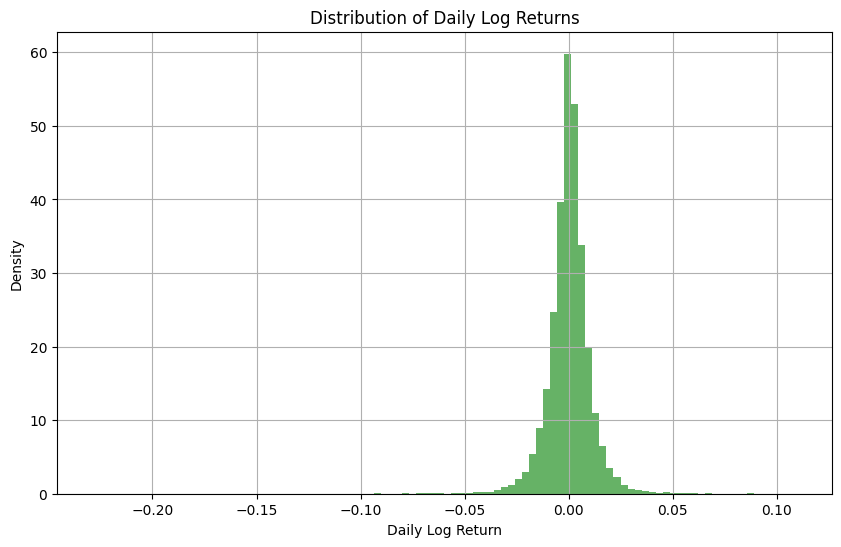

In [25]:
# plot the distribution of daily returns
plt.figure(figsize=(10, 6))
plt.hist(data["DailyReturn"], bins=100, density=True, alpha=0.6, color='g')
plt.title('Distribution of Daily Log Returns')
plt.xlabel('Daily Log Return')
plt.ylabel('Density')
plt.grid()
plt.show()

NOTE: If I use log returns, then there is a zero asset return (mean=0.0002). This would make the use of volatility as predictor for sign return described in Christofferson & Diebold (2006) not applicable to my project.

In [26]:
# Check for normality of returns
jb_stat, jb_p = stats.jarque_bera(data["DailyReturn"].dropna())
print(f"Jarque-Bera test statistic: {jb_stat}, p-value: {jb_p}")

Jarque-Bera test statistic: 404272.34287851123, p-value: 0.0


Hence, the Daily Returns do not follow a normal distribution and sign forecastibility with zero mean asset return but asymmetric distribution from [Christofferson et al.](https://economics.sas.upenn.edu/pier/working-paper/2006/direction-change-forecasts-based-conditional-variance-skewness-and-kurtosis) (2007) could be applied. By the descriptive statistics, it already becomes apparent that there is excess kurtosis, since the minimum return is roughly 22 st.dev. away from the mean. The probability for this to happen is so small, that this return would be even unlikely if we get a return every nanosecond from the start of the universe. Since Pr(Z>22)=2.44x10^-107 for a st.normal distr. Whereas, the universe exists for roughly 4,35x10^26=13,800,000,000x365x24x3600x10^9 nanoseconds.

In [27]:
# get annualized realized volatility
data['Realized_Vol_5d'] = data['DailyReturn'].rolling(window=5).std() * np.sqrt(252)
data['Realized_Vol_20d'] = data['DailyReturn'].rolling(window=20).std() * np.sqrt(252)

# Deep Learning for Sign Classification

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Create loss function that maximizes classification accuracy

In [29]:
class MaximumUtilityLoss(nn.Module):
    """
    Differentiable approximation of the Elliott-Lieli (2013) Maximum Utility estimator.
    Optimizes correct classification rather than probability calibration.
    """
    def __init__(self, c=0.0, sharpness=10.0, w_pos=1.0, w_neg=1.0):
        super().__init__()
        self.c = c
        self.sharpness = sharpness
        self.w_pos = w_pos
        self.w_neg = w_neg

    def forward(self, logits, y):
        y_sign = 2 * y - 1 # -1 or 1
        pred = torch.tanh(self.sharpness * (logits - self.c))  # get a sign approximation
        b = torch.where(y > 0.5, self.w_pos, self.w_neg)
        loss = 1-torch.mean(b * y_sign * pred)
        return loss

In [30]:
NUMBER_OF_LAGS = 100  # number of lagged observations
HIDDEN_DIM = 64
NUM_LAYERS = 4
DROPOUT = 0.0
BATCH_SIZE = 32
NUMBER_OF_EPOCHS = 50
CLASSIFICATION_THRESHOLD = 0.5
LR = 3e-4

TODO: Add more variables

In [31]:
ten_y_tbill = yf.download("^TNX", start="1962-01-02", end="2015-01-01", auto_adjust=True)
three_month_tbill = yf.download("^IRX", start="1962-01-02", end="2015-01-01", auto_adjust=True)
oil_price = yf.download("CL=F", start="1962-01-02", end="2015-01-01", auto_adjust=True)
vix_index = yf.download("^VIX", start="1962-01-02", end="2015-01-01", auto_adjust=True)
# merge Open price of interest rates with main data
data = data.merge(ten_y_tbill[["Open"]], left_index=True, right_index=True, how="left", suffixes=('', '_TNX'))
data = data.merge(three_month_tbill[["Open"]], left_index=True, right_index=True, how="left", suffixes=('', '_IRX'))
data = data.merge(oil_price[["Open"]], left_index=True, right_index=True, how="left", suffixes=('', '_CL'))
data = data.merge(vix_index[["Open"]], left_index=True, right_index=True, how="left", suffixes=('', '_VIX'))

# Drop MultiIndex in columns
data.columns = ['_'.join([str(level) for level in col if level]).replace('^', '') for col in data.columns]
data = data.rename(columns={
    ('Open_TNX'): ('ten_y_tnotes'),   
    ('Open_IRX'): ('three_months_tbills'),
    ('Open_CL=F'): ('oil_price'),
    ('Open_VIX'): ('vix_index')
})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [32]:
data.to_csv("sp500_with_features.csv")

In [33]:
# print nan values per column
#print(data.isna().sum())

In [34]:
# Add lagged returns as features
data['Return_Lag1'] = data['DailyReturn'].shift(1)
data['oil_price_return'] = np.log(data['oil_price']).diff()
data['vix_return'] = np.log(data['vix_index']).diff()

#data.drop(columns=['oil_price', 'oil_price_return', 'vix_index', 'vix_return'], inplace=True)  # dropping oil price due to too many NaNs
data = data.dropna()

# Feature matrix
features = np.column_stack([
    data['Realized_Vol_5d'].values,
    data['Realized_Vol_20d'].values,
    data['Return_Lag1'].values,
    data['Volume_change'].values,
    data['Trading_range'].values,
    data['ten_y_tnotes'].values,
    data['three_months_tbills'].values,
    data['oil_price_return'].values,
    data['vix_index'].values,
    data['vix_return'].values
])

input_variables = features.shape[1]

In [35]:
# Create lagged feature matrix for LSTM
def create_lagged_matrix_multifeature(X, window):
    out = []
    for i in range(window, len(X)):
        out.append(X[i-window:i, :])
    return np.array(out)

X_lagged = create_lagged_matrix_multifeature(features, NUMBER_OF_LAGS)
y_target = data['Sign_1d'].values[NUMBER_OF_LAGS:]

## Define LSTM Model

In [36]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, num_layers=1, dropout=0.0):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.0)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [37]:
dates_lagged = data.index[NUMBER_OF_LAGS:] 
years = dates_lagged.year
unique_years = np.unique(years).astype(int)
min_year = int(unique_years.min())
max_year = int(unique_years.max())

# require at least this many trading observations for a year to be considered "full"
MIN_DAYS_PER_YEAR = 200

# find first test_year such that test_year and previous 3 years each have >= MIN_DAYS_PER_YEAR samples
first_valid_test_year = None
for cand in range(min_year + 3, max_year + 1):
    train_years = [cand - 3, cand - 2, cand - 1]
    counts = {y: np.sum(years == y) for y in train_years + [cand]}
    if all(counts[y] >= MIN_DAYS_PER_YEAR for y in train_years + [cand]):
        first_valid_test_year = cand
        print("First valid test year:", first_valid_test_year)
        break

if first_valid_test_year is None:
    raise RuntimeError("No calendar-aligned test year found with sufficient data. Lower MIN_DAYS_PER_YEAR or check your date range.")


First valid test year: 2004


In [38]:
from tqdm import tqdm

window_results = []
window_no = 0

for test_year in tqdm(range(first_valid_test_year, max_year+1), desc="yearly rolling window"):
    window_no += 1
    train_years = [test_year - 3, test_year - 2, test_year - 1]
    train_idx = np.where(np.isin(years, train_years))[0]
    test_idx  = np.where(years == test_year)[0]

    if len(train_idx) < 700 or len(test_idx) < 230:
        raise ValueError("The data length suggests there is insufficient data in window {}.".format(window_no))

    # prepare split
    X_tr = X_lagged[train_idx]
    y_tr = y_target[train_idx]
    X_te = X_lagged[test_idx]
    y_te = y_target[test_idx]

    # tensors
    X_tr_t = torch.tensor(X_tr, dtype=torch.float32)
    y_tr_t = torch.tensor(y_tr.reshape(-1,1), dtype=torch.float32)
    X_te_t = torch.tensor(X_te, dtype=torch.float32)

    # save train and test date range
    train_start_date = dates_lagged[train_idx[0]].date()
    train_end_date   = dates_lagged[train_idx[-1]].date()
    test_start_date  = dates_lagged[test_idx[0]].date()
    test_end_date    = dates_lagged[test_idx[-1]].date()

    # new model per window
    model_window = SimpleLSTM(input_dim=input_variables, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT)
    optimizer = optim.Adam(model_window.parameters(), lr=LR)
    criterion = nn.BCEWithLogitsLoss()

    ds = TensorDataset(X_tr_t, y_tr_t)
    data_loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

    # train
    model_window.train()
    for epoch in range(NUMBER_OF_EPOCHS):
        epoch_loss = 0.0
        for X_batch, y_batch in data_loader:
            optimizer.zero_grad()
            logits = model_window(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
        if epoch % 49 == 0:
            avg_loss = epoch_loss / len(ds)
            #print(f"window start={dates_lagged[start].date()} epoch={epoch} avg_loss={avg_loss:.6f}")

    # predict for the whole test year
    model_window.eval()
    with torch.no_grad():
        logits_test = model_window(X_te_t).squeeze()         # shape (TEST_DAYS,)
        probs = torch.sigmoid(logits_test).cpu().numpy()
        preds = (probs > CLASSIFICATION_THRESHOLD).astype(int)

    window_df = pd.DataFrame({
        'Actual_Sign': y_te,
        'Predicted_Sign': preds,
        'Pos_probability': probs,
        'Train_Start': train_start_date,
        'Train_End': train_end_date,
        'Test_Start': test_start_date,
        'Test_End': test_end_date
    }, index=dates_lagged[test_idx])

    window_results.append(window_df)

# combine windows
if window_results:
    rolling_results = pd.concat(window_results).sort_index()
    overall_acc = (rolling_results['Actual_Sign'] == rolling_results['Predicted_Sign']).mean()
    print(f"Rolling annual OOS accuracy: {overall_acc:.4f}")
    rolling_results.to_csv("LSTM_rolling_annual_results.csv")
else:
    print("No windows produced - check TRAIN_DAYS/TEST_DAYS and data length.")

yearly rolling window: 100%|██████████| 11/11 [11:50<00:00, 64.59s/it]

Rolling annual OOS accuracy: 0.5329


In [39]:
# count parameters
sum(p.numel() for p in model_window.parameters() if p.requires_grad)

119361

#parameters: 
- 1st hidden layer: 4x(#features x hidden_size + hidden_size x hidden_size) weights + hidden_size biases
- subsequent hidden layers: 4x(hidden_size x hidden_size + hidden_size x hidden_size) + hidden_size biases
- last layer (fully connceted layer): hidden_size + 1

Text(0.5, 1.0, 'Predicted Probability of Positive Return')

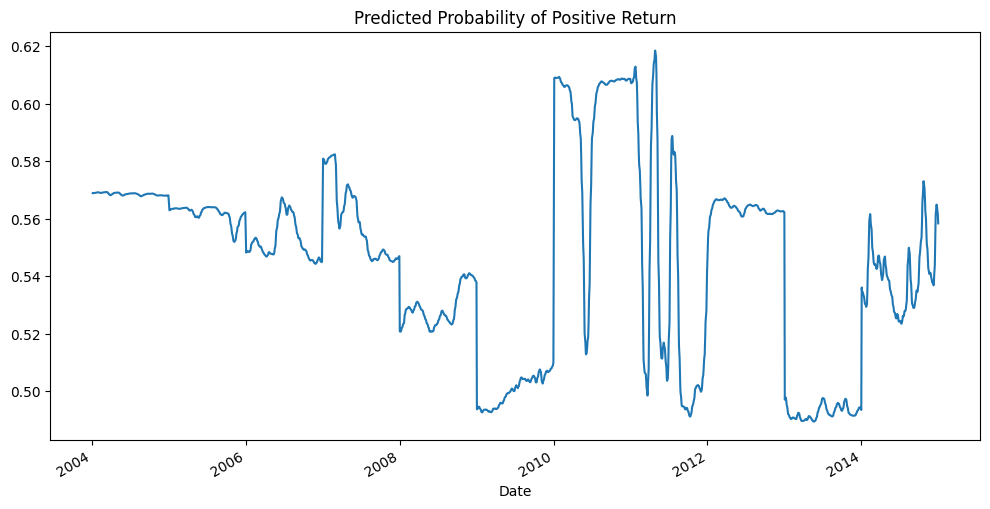

In [40]:
rolling_results["Pos_probability"].plot(figsize=(12,6))
plt.title("Predicted Probability of Positive Return")

### Out of sample Prediction

In [41]:
from sklearn.metrics import classification_report, accuracy_score

# Classification report
print("Classification Report:")
print(classification_report(rolling_results['Actual_Sign'], rolling_results['Predicted_Sign']))
print("Accuracy:", accuracy_score(rolling_results['Actual_Sign'], rolling_results['Predicted_Sign']))

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.15      0.22      1230
           1       0.55      0.85      0.67      1523

    accuracy                           0.53      2753
   macro avg       0.49      0.50      0.44      2753
weighted avg       0.50      0.53      0.47      2753

Accuracy: 0.5328732292045042


## Evaluate results for each Year individually

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# rolling_results should exist from previous cell
if 'rolling_results' not in globals():
    raise RuntimeError("rolling_results not found — run the rolling evaluation cell first.")

# determine grouping year (prefer explicit Test_Year if present)
if 'Test_Year' in rolling_results.columns:
    years_idx = rolling_results['Test_Year']
else:
    years_idx = rolling_results.index.year

summary_rows = []
per_year_reports = {}

for y in sorted(years_idx.unique()):
    mask = (years_idx == y)
    y_true = rolling_results.loc[mask, 'Actual_Sign'].values
    y_pred = rolling_results.loc[mask, 'Predicted_Sign'].values

    if len(y_true) == 0:
        continue

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    summary_rows.append({
        'Year': int(y),
        'N': len(y_true),
        'Accuracy': acc,
        'Precision 1': prec,
        'Recall 1': rec,
        'F1': f1,
        'TN': int(cm[0,0]) if cm.shape == (2,2) else 0,
        'FP': int(cm[0,1]) if cm.shape == (2,2) else 0,
        'FN': int(cm[1,0]) if cm.shape == (2,2) else 0,
        'TP': int(cm[1,1]) if cm.shape == (2,2) else 0
    })

    # store full sklearn report per year
    per_year_reports[y] = classification_report(y_true, y_pred, zero_division=0, output_dict=False)

summary_df = pd.DataFrame(summary_rows).sort_values('Year').set_index('Year')
print("Per-year summary:")
print(summary_df)

Per-year summary:
        N  Accuracy  Precision 1  Recall 1        F1   TN   FP   FN   TP
Year                                                                    
2004  247  0.558704     0.558704  1.000000  0.716883    0  109    0  138
2005  247  0.562753     0.562753  1.000000  0.720207    0  108    0  139
2006  246  0.565041     0.565041  1.000000  0.722078    0  107    0  139
2007  251  0.545817     0.545817  1.000000  0.706186    0  114    0  137
2008  253  0.498024     0.498024  1.000000  0.664908    0  127    0  126
2009  252  0.543651     0.587413  0.600000  0.593640   53   59   56   84
2010  251  0.569721     0.569721  1.000000  0.725888    0  108    0  143
2011  252  0.503968     0.532663  0.768116  0.629080   21   93   32  106
2012  250  0.528000     0.528000  1.000000  0.691099    0  118    0  132
2013  252  0.416667     0.000000  0.000000  0.000000  105    0  147    0
2014  252  0.571429     0.571429  1.000000  0.727273    0  108    0  144


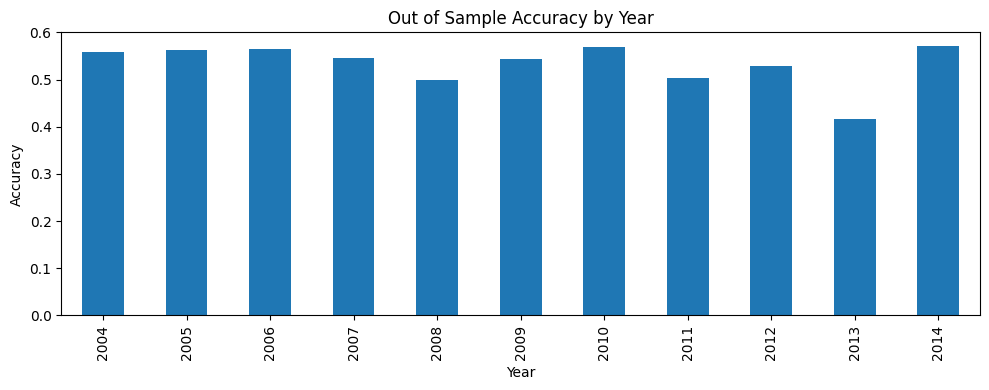

In [43]:
ax = summary_df['Accuracy'].plot(kind='bar', figsize=(10,4), title='Out of Sample Accuracy by Year')
ax.set_ylabel('Accuracy')
plt.tight_layout()